## Introduction
In this notebook we will demonstrates how to accelerate TensorFlow Keras applications on training workloads with BigDL-Nano.

### Prepare Environment
Before you start with Apis delivered by bigdl-nano, you have to make sure BigDL-Nano is correctly installed for TensorFlow. If not, please follow [this](../../../../../docs/readthedocs/source/doc/Nano/Overview/nano.md) to set up your environment.

The optimizations in BigDL-Nano are delivered through BigDL-Nano’s `Model` and `Sequential` classes. For most cases, you can just replace your `tf.keras.Model` to `bigdl.nano.tf.keras.Model` and `tf.keras.Sequential` to `bigdl.nano.tf.keras.Sequential` to benefits from BigDL-Nano.

In [1]:
from bigdl.nano.tf.keras import Model, Sequential

### Load Stanford Dogs Dataset
Here we load data from tensorflow_datasets(hereafter [TFDS](https://www.tensorflow.org/datasets)). The [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html) contains images of 120 breeds of dogs around the world. There are 20,580 images, out of which 12,000 are used for training and 8580 for testing.

In [2]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    data_dir="../data/",
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)


/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-28 00:29:02.467008: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Visualizing the Data
The following code shows the first 6 images with their labels.

,image,label
0,,36 (n02094433-yorkshire_terrier)
1,,118 (n02115913-dhole)
2,,46 (n02097130-giant_schnauzer)
3,,103 (n02111129-leonberg)
4,,113 (n02113624-toy_poodle)
5,,116 (n02113978-mexican_hairless)

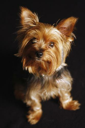
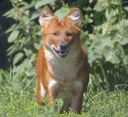
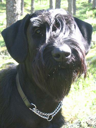
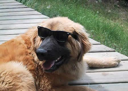
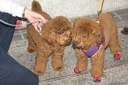
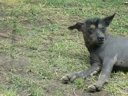

In [3]:
tfds.as_dataframe(ds_train.take(6), ds_info)

### Prepare Inputs
When the dataset include images with various size, we need to resize them into a shared size. The labels are put into one-hot. The dataset is batched.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
img_size = 224
num_classes = ds_info.features['label'].num_classes
batch_size = 64
data_augmentation = Sequential([
        layers.RandomFlip(),
        layers.RandomRotation(factor=0.15),
    ])
def preprocessing(img, label):
    img, label =  tf.image.resize(img, (img_size, img_size)), tf.one_hot(label, num_classes)
    return data_augmentation(img), label
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().repeat().map(preprocessing).batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
ds_test = ds_test.map(preprocessing).batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)

### Build Model
BigDL-Nano's `Model` (`bigdl.nano.tf.keras.Model`) and `Sequential` (`bigdl.nano.tf.keras.Sequential`) classes have identical APIs with `tf.keras.Model` and `tf.keras.Sequential`.
Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on the Stanford Dogs dataset.

In [5]:
from tensorflow.keras.applications import EfficientNetB0
def make_model(learning_rate=1e-2):
    inputs = layers.Input(shape = (img_size, img_size, 3))

    backbone = EfficientNetB0(include_top=False, input_tensor=inputs)

    backbone.trainable = False

    x = layers.GlobalAveragePooling2D(name='avg_pool')(backbone.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = Model(inputs, outputs, name='EfficientNet')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy']
    )
    return model

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy']
    )

### Training

In [11]:
from time import time
steps_per_epoch = ds_info.splits['train'].num_examples // batch_size
validation_steps = ds_info.splits['test'].num_examples // batch_size

model_default = make_model()

# Shorten fitting time during test
import os
freezed_epochs = int(os.environ.get('epochs', 15))
unfreeze_epochs = int(os.environ.get('epochs', 10))
steps_per_epoch = int(os.environ.get('STEPS', steps_per_epoch))
validation_steps = int(os.environ.get('STEPS', validation_steps))

start = time()
model_default.fit(ds_train,
                  epochs=freezed_epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=ds_test,
                  validation_steps=validation_steps)
unfreeze_model(model_default)
his_default = model_default.fit(ds_train,
                                epochs=unfreeze_epochs,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=ds_test,
                                validation_steps=validation_steps)
fit_time_default = time() - start

Epoch 1/15
  2/187 [..............................] - ETA: 1:30 - loss: 5.8608 - accuracy: 0.0391 

tcmalloc: large alloc 2147483648 bytes == 0x556a33c8c000 @  0x7f7bae94bd3f 0x7f7bae9820c0 0x7f7bae985082 0x7f7bae985243 0x7f7b9e0cf402 0x7f7b92469eb0 0x7f7b9248a0b5 0x7f7b9248d9ea 0x7f7b9248df69 0x7f7b9248e2d1 0x7f7b92482ce3 0x7f7b8db48051 0x7f7b8d9a338d 0x7f7b8d736087 0x7f7b8d73691e 0x7f7b8d736b1d 0x7f7b93716bfd 0x7f7b8db49d7c 0x7f7b8dad3cec 0x7f7b92e9676e 0x7f7b92e931f3 0x7f7b8e225313 0x7f7bae783609 0x7f7bae6a8133


 61/187 [========>.....................] - ETA: 1:00 - loss: 3.8823 - accuracy: 0.3335

tcmalloc: large alloc 4294967296 bytes == 0x556ab8194000 @  0x7f7bae94bd3f 0x7f7bae9820c0 0x7f7bae985082 0x7f7bae985243 0x7f7b9e0cf402 0x7f7b92469eb0 0x7f7b9248a0b5 0x7f7b9248d9ea 0x7f7b9248df69 0x7f7b9248e2d1 0x7f7b92482ce3 0x7f7b8db48051 0x7f7b8d9a338d 0x7f7b8d736087 0x7f7b8d73691e 0x7f7b8d736b1d 0x7f7b93716bfd 0x7f7b8db49d7c 0x7f7b8dad3cec 0x7f7b92e9676e 0x7f7b92e931f3 0x7f7b8e225313 0x7f7bae783609 0x7f7bae6a8133


187/187 [==============================] - 162s 843ms/step - loss: 3.2832 - accuracy: 0.4130 - val_loss: 1.8294 - val_accuracy: 0.5099
Epoch 2/15
187/187 [==============================] - ETA: 0s - loss: 1.6866 - accuracy: 0.5690

tcmalloc: large alloc 8589934592 bytes == 0x556bc3220000 @  0x7f7bae94bd3f 0x7f7bae9820c0 0x7f7bae985082 0x7f7bae985243 0x7f7b9e0cf402 0x7f7b92469eb0 0x7f7b9248a0b5 0x7f7b9248d9ea 0x7f7b9248df69 0x7f7b9248e2d1 0x7f7b92482ce3 0x7f7b8db48051 0x7f7b8d9a338d 0x7f7b8d736087 0x7f7b8d73691e 0x7f7b8d736b1d 0x7f7b93716bfd 0x7f7b8db49d7c 0x7f7b8dad3cec 0x7f7b92e9676e 0x7f7b92e931f3 0x7f7b8e225313 0x7f7bae783609 0x7f7bae6a8133


187/187 [==============================] - 151s 809ms/step - loss: 1.6866 - accuracy: 0.5690 - val_loss: 1.5741 - val_accuracy: 0.5744
Epoch 3/15
187/187 [==============================] - 149s 801ms/step - loss: 1.3531 - accuracy: 0.6176 - val_loss: 1.5735 - val_accuracy: 0.5819
Epoch 4/15
187/187 [==============================] - 149s 802ms/step - loss: 1.2432 - accuracy: 0.6441 - val_loss: 1.5697 - val_accuracy: 0.5852
Epoch 5/15
187/187 [==============================] - 146s 782ms/step - loss: 1.2269 - accuracy: 0.6482 - val_loss: 1.5741 - val_accuracy: 0.5850
Epoch 6/15
187/187 [==============================] - 138s 738ms/step - loss: 1.1833 - accuracy: 0.6572 - val_loss: 1.6217 - val_accuracy: 0.5841
Epoch 7/15
187/187 [==============================] - 127s 679ms/step - loss: 1.1500 - accuracy: 0.6711 - val_loss: 1.6232 - val_accuracy: 0.5913
Epoch 8/15
187/187 [==============================] - 107s 577ms/step - loss: 1.1322 - accuracy: 0.6768 - val_loss: 1.6334 - val_accura

#### Multi-Instance Training
BigDL-Nano makes it very easy to conduct multi-instance training correctly. You can just set the `num_processes` parameter in the `fit` method in your `Model` or `Sequential` object and BigDL-Nano will launch the specific number of processes to perform data-parallel training.

In [10]:
start = time()
model_multi = make_model()

model_multi.fit(ds_train,
                epochs=freezed_epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=ds_test,
                validation_steps=validation_steps,
                num_processes=4,
                backend='multiprocessing')
unfreeze_model(model_multi)
his_multi = model_multi.fit(ds_train,
                            epochs=unfreeze_epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=ds_test,
                            validation_steps=validation_steps,
                            num_processes=4,
                            backend='multiprocessing')
fit_time_multi = time() - start


tcmalloc: large alloc 1073741824 bytes == 0x556946dca000 @  0x7f7bae94bd3f 0x7f7bae9820c0 0x7f7bae985082 0x7f7bae985243 0x7f7b9e0cf402 0x7f7b92469eb0 0x7f7b9248a0b5 0x7f7b9248d9ea 0x7f7b9248df69 0x7f7b9248e2d1 0x7f7b92482ce3 0x7f7b8db48051 0x7f7b8d9a338d 0x7f7b8d736087 0x7f7b8d73691e 0x7f7b8d736b1d 0x7f7b96689c92 0x7f7b966a26d8 0x7f7b966f6e3e 0x7f7b8db49d7c 0x7f7b8dad3cec 0x7f7b92e9676e 0x7f7b92e931f3 0x7f7b8e225313 0x7f7bae783609 0x7f7bae6a8133
2022-07-28 00:30:34.314983: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-07-28 00:30:42.039144: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may ch

INFO:tensorflow:Assets written to: /tmp/tmpc14eknez/temp_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpc14eknez/temp_model/assets
/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
2022-07-28 00:31:02.367754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other oper

Epoch 1/15
  1/187 [..............................] - ETA: 25:13 - loss: 6.5813 - accuracy: 0.0000e+00

tcmalloc: large alloc 1073741824 bytes == 0x5626b4a02000 @  0x7f7d9d8acd3f 0x7f7d9d8e30c0 0x7f7d9d8e6082 0x7f7d9d8e6243 0x7f7d977b5402 0x7f7d8bb4feb0 0x7f7d8bb700b5 0x7f7d8bb739ea 0x7f7d8bb73f69 0x7f7d8bb742d1 0x7f7d8bb68ce3 0x7f7d8722e051 0x7f7d8708938d 0x7f7d86e1c087 0x7f7d86e1c91e 0x7f7d86e1cb1d 0x7f7d9280dbf5 0x7f7d8722fd7c 0x7f7d871b9cec 0x7f7d8c57c76e 0x7f7d8c5791f3 0x7f7d8790b313 0x7f7d9d6e4609 0x7f7d9d609133
tcmalloc: large alloc 1073741824 bytes == 0x55cc943ba000 @  0x7fe943ec7d3f 0x7fe943efe0c0 0x7fe943f01082 0x7fe943f01243 0x7fe93ddd0402 0x7fe93216aeb0 0x7fe93218b0b5 0x7fe93218e9ea 0x7fe93218ef69 0x7fe93218f2d1 0x7fe932183ce3 0x7fe92d849051 0x7fe92d6a438d 0x7fe92d437087 0x7fe92d43791e 0x7fe92d437b1d 0x7fe933417bfd 0x7fe92d84ad7c 0x7fe92d7d4cec 0x7fe932b9776e 0x7fe932b941f3 0x7fe92df26313 0x7fe943cff609 0x7fe943c24133


  2/187 [..............................] - ETA: 43s - loss: 6.1298 - accuracy: 0.0156      

tcmalloc: large alloc 1073741824 bytes == 0x562c31226000 @  0x7f5483db7d3f 0x7f5483dee0c0 0x7f5483df1082 0x7f5483df1243 0x7f547dcc0402 0x7f547205aeb0 0x7f547207b0b5 0x7f547207e9ea 0x7f547207ef69 0x7f547207f2d1 0x7f5472073ce3 0x7f546d739051 0x7f546d59438d 0x7f546d327087 0x7f546d32791e 0x7f546d327b1d 0x7f5478d18bf5 0x7f546d73ad7c 0x7f546d6c4cec 0x7f5472a8776e 0x7f5472a841f3 0x7f546de16313 0x7f5483bef609 0x7f5483b14133
tcmalloc: large alloc 1073741824 bytes == 0x55f8f28a6000 @  0x7fdf68d5fd3f 0x7fdf68d960c0 0x7fdf68d99082 0x7fdf68d99243 0x7fdf62c68402 0x7fdf57002eb0 0x7fdf570230b5 0x7fdf570269ea 0x7fdf57026f69 0x7fdf570272d1 0x7fdf5701bce3 0x7fdf526e1051 0x7fdf5253c38d 0x7fdf522cf087 0x7fdf522cf91e 0x7fdf522cfb1d 0x7fdf5dcc0bf5 0x7fdf526e2d7c 0x7fdf5266ccec 0x7fdf57a2f76e 0x7fdf57a2c1f3 0x7fdf52dbe313 0x7fdf68b97609 0x7fdf68abc133


 94/187 [==============>...............] - ETA: 20s - loss: 3.9023 - accuracy: 0.3419

tcmalloc: large alloc 2147483648 bytes == 0x562c738e8000 @  0x7f5483db7d3f 0x7f5483dee0c0 0x7f5483df1082 0x7f5483df1243 0x7f547dcc0402 0x7f547205aeb0 0x7f547207b0b5 0x7f547207e9ea 0x7f547207ef69 0x7f547207f2d1 0x7f5472073ce3 0x7f546d739051 0x7f546d59438d 0x7f546d327087 0x7f546d32791e 0x7f546d327b1d 0x7f5473307bfd 0x7f546d73ad7c 0x7f546d6c4cec 0x7f5472a8776e 0x7f5472a841f3 0x7f546de16313 0x7f5483bef609 0x7f5483b14133


 95/187 [==============>...............] - ETA: 20s - loss: 3.9011 - accuracy: 0.3426

tcmalloc: large alloc 2147483648 bytes == 0x55ccd66ca000 @  0x7fe943ec7d3f 0x7fe943efe0c0 0x7fe943f01082 0x7fe943f01243 0x7fe93ddd0402 0x7fe93216aeb0 0x7fe93218b0b5 0x7fe93218e9ea 0x7fe93218ef69 0x7fe93218f2d1 0x7fe932183ce3 0x7fe92d849051 0x7fe92d6a438d 0x7fe92d437087 0x7fe92d43791e 0x7fe92d437b1d 0x7fe933417bfd 0x7fe92d84ad7c 0x7fe92d7d4cec 0x7fe932b9776e 0x7fe932b941f3 0x7fe92df26313 0x7fe943cff609 0x7fe943c24133


 98/187 [==============>...............] - ETA: 19s - loss: 3.8907 - accuracy: 0.3431

tcmalloc: large alloc 2147483648 bytes == 0x5626f6a02000 @  0x7f7d9d8acd3f 0x7f7d9d8e30c0 0x7f7d9d8e6082 0x7f7d9d8e6243 0x7f7d977b5402 0x7f7d8bb4feb0 0x7f7d8bb700b5 0x7f7d8bb739ea 0x7f7d8bb73f69 0x7f7d8bb742d1 0x7f7d8bb68ce3 0x7f7d8722e051 0x7f7d8708938d 0x7f7d86e1c087 0x7f7d86e1c91e 0x7f7d86e1cb1d 0x7f7d8cdfcbfd 0x7f7d8722fd7c 0x7f7d871b9cec 0x7f7d8c57c76e 0x7f7d8c5791f3 0x7f7d8790b313 0x7f7d9d6e4609 0x7f7d9d609133


 99/187 [==============>...............] - ETA: 19s - loss: 3.8836 - accuracy: 0.3441

tcmalloc: large alloc 2147483648 bytes == 0x55f9350a6000 @  0x7fdf68d5fd3f 0x7fdf68d960c0 0x7fdf68d99082 0x7fdf68d99243 0x7fdf62c68402 0x7fdf57002eb0 0x7fdf570230b5 0x7fdf570269ea 0x7fdf57026f69 0x7fdf570272d1 0x7fdf5701bce3 0x7fdf526e1051 0x7fdf5253c38d 0x7fdf522cf087 0x7fdf522cf91e 0x7fdf522cfb1d 0x7fdf582afbfd 0x7fdf526e2d7c 0x7fdf5266ccec 0x7fdf57a2f76e 0x7fdf57a2c1f3 0x7fdf52dbe313 0x7fdf68b97609 0x7fdf68abc133


187/187 [==============================] - ETA: 0s - loss: 3.3275 - accuracy: 0.3993

2022-07-28 00:32:07.111959: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:32:07.117734: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:32:07.121816: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:32:07.123984: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:32:07.284777: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal

187/187 [==============================] - 78s 375ms/step - loss: 3.3275 - accuracy: 0.3993 - val_loss: 1.8672 - val_accuracy: 0.5146
Epoch 2/15
187/187 [==============================] - ETA: 0s - loss: 1.8147 - accuracy: 0.5446

2022-07-28 00:33:13.177990: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:33:13.187853: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:33:13.208463: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:33:13.225897: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 37s 197ms/step - loss: 1.8147 - accuracy: 0.5446
Epoch 3/15
187/187 [==============================] - ETA: 0s - loss: 1.4849 - accuracy: 0.5872

2022-07-28 00:33:49.336256: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:33:49.355667: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:33:49.359656: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:33:49.365850: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 193ms/step - loss: 1.4849 - accuracy: 0.5872
Epoch 4/15
187/187 [==============================] - ETA: 0s - loss: 1.3554 - accuracy: 0.6211

2022-07-28 00:34:25.460951: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:34:25.462177: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:34:25.465696: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:34:25.468829: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 193ms/step - loss: 1.3554 - accuracy: 0.6211
Epoch 5/15
187/187 [==============================] - ETA: 0s - loss: 1.3590 - accuracy: 0.6130

2022-07-28 00:35:01.340715: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:35:01.349397: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:35:01.365138: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:35:01.368322: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 192ms/step - loss: 1.3590 - accuracy: 0.6130
Epoch 6/15
187/187 [==============================] - ETA: 0s - loss: 1.3128 - accuracy: 0.6304

2022-07-28 00:35:37.653739: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:35:37.656918: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:35:37.659765: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:35:37.671318: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 194ms/step - loss: 1.3128 - accuracy: 0.6304
Epoch 7/15
187/187 [==============================] - ETA: 0s - loss: 1.2524 - accuracy: 0.6530

2022-07-28 00:36:12.904260: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:36:12.904603: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:36:12.907651: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:36:12.914987: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 35s 188ms/step - loss: 1.2524 - accuracy: 0.6530
Epoch 8/15
187/187 [==============================] - ETA: 0s - loss: 1.2640 - accuracy: 0.6432

2022-07-28 00:36:48.704248: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:36:48.707718: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:36:48.714381: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:36:48.717430: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 191ms/step - loss: 1.2640 - accuracy: 0.6432
Epoch 9/15
187/187 [==============================] - ETA: 0s - loss: 1.2508 - accuracy: 0.6478

2022-07-28 00:37:24.126118: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:37:24.128381: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:37:24.129396: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:37:24.132204: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 35s 189ms/step - loss: 1.2508 - accuracy: 0.6478
Epoch 10/15
187/187 [==============================] - ETA: 0s - loss: 1.2324 - accuracy: 0.6514

2022-07-28 00:38:00.376722: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:38:00.379909: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:38:00.386302: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:38:00.395678: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 194ms/step - loss: 1.2324 - accuracy: 0.6514
Epoch 11/15
187/187 [==============================] - ETA: 0s - loss: 1.2328 - accuracy: 0.6502

2022-07-28 00:38:36.155318: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:38:36.157367: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:38:36.168370: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:38:36.175275: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 191ms/step - loss: 1.2328 - accuracy: 0.6502
Epoch 12/15
187/187 [==============================] - 36s 190ms/step - loss: 1.2240 - accuracy: 0.6557


2022-07-28 00:39:11.812336: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:39:11.820780: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:39:11.822357: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:39:11.836746: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 13/15
187/187 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.6562

2022-07-28 00:39:47.932963: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:39:47.946924: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:39:47.947078: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:39:47.948247: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 193ms/step - loss: 1.2192 - accuracy: 0.6562
Epoch 14/15
187/187 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.6567

2022-07-28 00:40:23.553251: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:40:23.561062: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:40:23.566534: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:40:23.582342: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 190ms/step - loss: 1.2194 - accuracy: 0.6567
Epoch 15/15
187/187 [==============================] - ETA: 0s - loss: 1.1856 - accuracy: 0.6690

2022-07-28 00:40:59.123897: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:40:59.136430: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:40:59.136507: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:40:59.159897: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 36s 190ms/step - loss: 1.1856 - accuracy: 0.6690


2022-07-28 00:41:08.250641: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-28 00:41:08.334329: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-28 00:41:08.427185: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-28 00:41:08.449314: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = se

INFO:tensorflow:Assets written to: /tmp/tmpo82ojku4/temp_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpo82ojku4/temp_model/assets
/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
2022-07-28 00:42:45.893477: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other oper

Epoch 1/10
  1/187 [..............................] - ETA: 26:48 - loss: 0.7759 - accuracy: 0.7500

tcmalloc: large alloc 1073741824 bytes == 0x55a668304000 @  0x7f3bbdfaed3f 0x7f3bbdfe50c0 0x7f3bbdfe8082 0x7f3bbdfe8243 0x7f3bb7eb7402 0x7f3bac251eb0 0x7f3bac2720b5 0x7f3bac2759ea 0x7f3bac275f69 0x7f3bac2762d1 0x7f3bac26ace3 0x7f3ba7930051 0x7f3ba778b38d 0x7f3ba751e087 0x7f3ba751e91e 0x7f3ba751eb1d 0x7f3bb2f0fbf5 0x7f3ba7931d7c 0x7f3ba78bbcec 0x7f3bacc7e76e 0x7f3bacc7b1f3 0x7f3ba800d313 0x7f3bbdde6609 0x7f3bbdd0b133
tcmalloc: large alloc 1073741824 bytes == 0x55a51389c000 @  0x7ffaa274cd3f 0x7ffaa27830c0 0x7ffaa2786082 0x7ffaa2786243 0x7ffa9c655402 0x7ffa909efeb0 0x7ffa90a100b5 0x7ffa90a139ea 0x7ffa90a13f69 0x7ffa90a142d1 0x7ffa90a08ce3 0x7ffa8c0ce051 0x7ffa8bf2938d 0x7ffa8bcbc087 0x7ffa8bcbc91e 0x7ffa8bcbcb1d 0x7ffa976adbf5 0x7ffa8c0cfd7c 0x7ffa8c059cec 0x7ffa9141c76e 0x7ffa914191f3 0x7ffa8c7ab313 0x7ffaa2584609 0x7ffaa24a9133
tcmalloc: large alloc 1073741824 bytes == 0x55a7f762c000 @  0x7ff73812fd3f 0x7ff7381660c0 0x7ff738169082 0x7ff738169243 0x7ff732038402 0x7ff7263d2eb0 0x7ff7263f

 87/187 [============>.................] - ETA: 24s - loss: 1.0286 - accuracy: 0.7064

tcmalloc: large alloc 2147483648 bytes == 0x55a83abc4000 @  0x7ff73812fd3f 0x7ff7381660c0 0x7ff738169082 0x7ff738169243 0x7ff732038402 0x7ff7263d2eb0 0x7ff7263f30b5 0x7ff7263f69ea 0x7ff7263f6f69 0x7ff7263f72d1 0x7ff7263ebce3 0x7ff721ab1051 0x7ff72190c38d 0x7ff72169f087 0x7ff72169f91e 0x7ff72169fb1d 0x7ff72767fbfd 0x7ff721ab2d7c 0x7ff721a3ccec 0x7ff726dff76e 0x7ff726dfc1f3 0x7ff72218e313 0x7ff737f67609 0x7ff737e8c133


 95/187 [==============>...............] - ETA: 22s - loss: 1.0298 - accuracy: 0.7048

tcmalloc: large alloc 2147483648 bytes == 0x55a6ab0b8000 @  0x7f3bbdfaed3f 0x7f3bbdfe50c0 0x7f3bbdfe8082 0x7f3bbdfe8243 0x7f3bb7eb7402 0x7f3bac251eb0 0x7f3bac2720b5 0x7f3bac2759ea 0x7f3bac275f69 0x7f3bac2762d1 0x7f3bac26ace3 0x7f3ba7930051 0x7f3ba778b38d 0x7f3ba751e087 0x7f3ba751e91e 0x7f3ba751eb1d 0x7f3bad4febfd 0x7f3ba7931d7c 0x7f3ba78bbcec 0x7f3bacc7e76e 0x7f3bacc7b1f3 0x7f3ba800d313 0x7f3bbdde6609 0x7f3bbdd0b133
tcmalloc: large alloc 2147483648 bytes == 0x555aa8b36000 @  0x7f35c5041d3f 0x7f35c50780c0 0x7f35c507b082 0x7f35c507b243 0x7f35bef4a402 0x7f35b32e4eb0 0x7f35b33050b5 0x7f35b33089ea 0x7f35b3308f69 0x7f35b33092d1 0x7f35b32fdce3 0x7f35ae9c3051 0x7f35ae81e38d 0x7f35ae5b1087 0x7f35ae5b191e 0x7f35ae5b1b1d 0x7f35b4591bfd 0x7f35ae9c4d7c 0x7f35ae94ecec 0x7f35b3d1176e 0x7f35b3d0e1f3 0x7f35af0a0313 0x7f35c4e79609 0x7f35c4d9e133


187/187 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.7180

2022-07-28 00:43:55.547282: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:43:55.552608: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:43:55.554704: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:43:55.554724: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-07-28 00:43:55.719782: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal

187/187 [==============================] - 83s 400ms/step - loss: 0.9674 - accuracy: 0.7180 - val_loss: 1.4614 - val_accuracy: 0.6307
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.7472

2022-07-28 00:45:09.434862: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:45:09.443806: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:45:09.444495: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:45:09.460831: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 238ms/step - loss: 0.8549 - accuracy: 0.7472
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.7896 - accuracy: 0.7597

2022-07-28 00:45:53.805581: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:45:53.807725: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:45:53.809141: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:45:53.824431: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 237ms/step - loss: 0.7896 - accuracy: 0.7597
Epoch 4/10
187/187 [==============================] - 45s 238ms/step - loss: 0.7554 - accuracy: 0.7686


2022-07-28 00:46:38.442024: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:46:38.445297: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:46:38.459651: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:46:38.465653: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 5/10
187/187 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7806

2022-07-28 00:47:23.061400: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:47:23.065284: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:47:23.065398: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:47:23.066755: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 45s 238ms/step - loss: 0.7209 - accuracy: 0.7806
Epoch 6/10
187/187 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7962

2022-07-28 00:48:07.520382: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:48:07.520967: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:48:07.523656: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:48:07.530623: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 238ms/step - loss: 0.6696 - accuracy: 0.7962
Epoch 7/10
187/187 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.8120

2022-07-28 00:48:51.988196: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:48:51.989320: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:48:51.991571: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:48:51.994026: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 238ms/step - loss: 0.6132 - accuracy: 0.8120
Epoch 8/10
187/187 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.8084

2022-07-28 00:49:35.944476: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:49:35.945621: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:49:35.949108: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:49:35.955639: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 235ms/step - loss: 0.6103 - accuracy: 0.8084
Epoch 9/10
187/187 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.8146

2022-07-28 00:50:20.408259: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:50:20.413000: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:50:20.426132: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:50:20.449124: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 238ms/step - loss: 0.5850 - accuracy: 0.8146
Epoch 10/10
187/187 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.8260

2022-07-28 00:51:04.630699: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:51:04.639688: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:51:04.641352: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-07-28 00:51:04.663649: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


187/187 [==============================] - 44s 236ms/step - loss: 0.5612 - accuracy: 0.8260


2022-07-28 00:51:13.919106: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-28 00:51:13.927762: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-28 00:51:14.091379: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-28 00:51:14.146152: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = se

### Summary

In [12]:
template = """
|        Precision     | Fit Time(s)       | Accuracy(%) |
|        Default       |       {:5.2f}       |    {:5.2f}    |
|     Multi-Instance   |       {:5.2f}       |    {:5.2f}    |
"""
summary = template.format(
    fit_time_default, his_default.history['val_accuracy'][-1] * 100,
    fit_time_multi, his_multi.history['val_accuracy'][-1] * 100,
)
print(summary)


|        Precision     | Fit Time(s)       | Accuracy(%) |
|        Default       |       3292.38       |    63.86    |
|     Multi-Instance   |       1309.44       |    63.07    |

